### Imports

In [1]:
import torch.nn as nn
import pandas as pd
import torch
import torchvision as tv
# import skimage as skimg
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
import random
import math


### Check Device

In [2]:
import torch.version


print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.6


### Inspect Data

In [3]:
train_labels = pd.read_csv('D:/allforwork/AI/nnsp/NS-2025-00-data/train_labels.csv')
train_labels.head(5)

,file_name,label
0,1.png,18
1,2.png,69
2,3.png,82
3,4.png,63
4,5.png,69


In [4]:
print(train_labels['label'].min(), train_labels['label'].max())
print(train_labels.value_counts('label').sort_values())

0 101
label
6      20
20     20
33     20
2      20
0      20
     ... 
88    164
72    174
45    176
76    231
50    238
Name: count, Length: 102, dtype: int64


In [5]:
img_path = './NS-2025-00-data/train_images'
img_data = []
for i in range(6149):
    f = Image.open(f'{img_path}/{i + 1}.png').convert("RGB")
    img_data.append(f)

In [10]:
f = Image.open(f'{img_path}/200.png')
f_n = np.array(f)

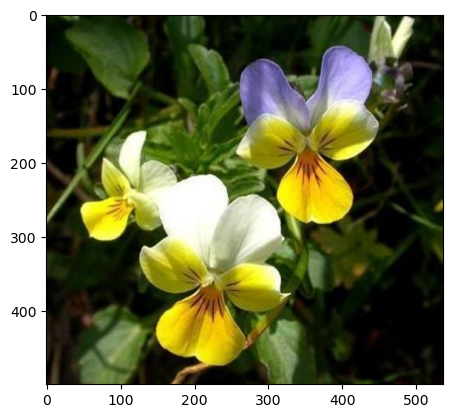

In [11]:
plt.imshow(f_n)

In [12]:
print(f_n[0][0])

[25 48  6]


### Prepare the dataset

In [6]:
train_transform = tv.transforms.Compose([
    # tv.transforms.Resize(512),
    tv.transforms.RandomCrop(384),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = tv.transforms.Compose([
    # tv.transforms.Resize(512),
    tv.transforms.CenterCrop(384),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [7]:
dataset_size = 6149

dataset = []

labeled_img = [[] for i in range(102)]

for i in range(dataset_size):
    label = train_labels['label'].iloc[i]
    path = f'{img_path}/{i + 1}.png'
    img = img_data[i]
    labeled_img[label].append(i)

train_dataset_img = []
train_dataset_labels = []
val_dataset_img = []
val_dataset_labels = []
val_p = 0.2

for i in range(102):
    siz = len(labeled_img[i])
    sub_siz = math.ceil(siz*val_p)
    val_data = random.sample(labeled_img[i], k=sub_siz)

    # label_vec = [0.0 for j in range(102)]
    # label_vec[i] = 1.0

    val_dataset_img.extend([val_transform(img_data[img_idx]) for img_idx in val_data])
    # val_dataset_labels.extend([np.array(label_vec)] * sub_siz)
    val_dataset_labels.extend([i] * sub_siz)

    train_img = [train_transform(img_data[img_idx]) for img_idx in labeled_img[i] if img_idx not in val_data]
    train_dataset_img.extend(train_img)
    # train_dataset_labels.extend([np.array(label_vec)] * len(train_paths))
    train_dataset_labels.extend([i] * len(train_img))


In [8]:
train_dataset = []
val_dataset = []
for i in range(len(train_dataset_img)):
    train_dataset.append((train_dataset_img[i], train_dataset_labels[i]))
for i in range(len(val_dataset_img)):
    val_dataset.append((val_dataset_img[i], val_dataset_labels[i]))


In [10]:
random.shuffle(train_dataset)
random.shuffle(val_dataset)
print(train_dataset[0][0].shape)

torch.Size([3, 384, 384])


In [11]:
train_loader = []
val_loader = []
batch_siz = 32
for i in range(0, len(train_dataset), batch_siz):
    imgs = []
    labels = []
    for j in range(i, min(i + batch_siz, len(train_dataset))):
        imgs.append(train_dataset[j][0])
        labels.append(train_dataset[j][1])
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)
    train_loader.append((imgs, labels))

for i in range(0, len(val_dataset), batch_siz):
    imgs = []
    labels = []
    for j in range(i, min(i + batch_siz, len(val_dataset))):
        imgs.append(val_dataset[j][0])
        labels.append(val_dataset[j][1])
    imgs = torch.stack(imgs)
    labels = torch.tensor(labels)
    val_loader.append((imgs, labels))

### Training

In [ ]:
model = tv.models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(512, 102),
    nn.Softmax(1)
)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_log = []


In [ ]:

epochs = 1
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    
    # Train
    model.train()
    siz = len(train_dataset_img)
    for t, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        
        current = t * batch_siz + len(X)
        if t%50 == 0:
            print(f'loss: {loss.item():>7f} [{current:>5d}/{siz:>5d}]')


    # Eval
    model.eval()
    siz = len(val_dataset)
    num_batches = len(val_loader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y) in val_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    loss_log.append(test_loss)
    correct /= siz
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
plt.plot(loss_log)

v0 97.3%

In [15]:
# save model?
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'batch_size': 32,
    'cut_size': 384
},'NS-00-v0-20250420-resnet18-epoch-65.pt')


print("Done!")

Done!


### Predict

In [18]:
img_path = './NS-2025-00-data/test_images'
test_data = []
for i in range(2040):
    f = Image.open(f'{img_path}/{i + 1}.png').convert("RGB")
    test_data.append(val_transform(f))

In [20]:
model_file = torch.load('D:/allforwork/AI/nnsp/NS-00-v0-20250420-resnet18-epoch-65.pt', weights_only=False)
model = tv.models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(512, 102),
    nn.Softmax(1)
)
model.load_state_dict(model_file['model_state_dict'])

<All keys matched successfully>

In [22]:
model.to(device)
model.eval()
result_data = []
for i in range(2040):
    with torch.no_grad():
        X = test_data[i].unsqueeze(0)
        X = X.to(device)
        pred = model(X)
        pred = pred.argmax(1)
    result_data.append({"file_name":f'{i + 1}.png', "label":pred.item()})

result_df = pd.DataFrame(result_data, columns=['file_name', 'label'])
result_df.to_csv("D:/allforwork/AI/nnsp/NS-2025-00-data/results.csv", index=False)